In [0]:
# Requirements
!pip install pycountry-convert
!pip install chart-studio

In [0]:
# import des librairies 
import requests
import pandas as pd

import pycountry 
import plotly.express as px

import numpy as np
import re
from datetime import datetime

In [0]:
# import data (world but USA)

urls = {'confirmed':'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
      #  'recovered':'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
      #   'deaths': 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
       }

In [0]:
df = pd.DataFrame()
data = pd.DataFrame()
for case, url in urls.items() :
    df = pd.DataFrame()
    df = pd.read_csv(url, error_bad_lines=False)
    df['Province/State'] = df['Province/State'].apply(lambda x : "" if x  else str(x))
    
    df.columns = [re.sub('/20$','/2020',col) for col in df.columns]
    df.columns = [datetime.strptime(col, '%m/%d/%Y').strftime('%Y/%m/%d')
                  if col.endswith('2020') else col.strip()
                 for col in df.columns]
    data = pd.concat([data, df], ignore_index=False, axis =0)


## 2. Data Prep

In [7]:
# We create a new dataset only with the count for the end of each month
data['january-20'] = data['2020/01/31']
data['february-20'] = data['2020/02/29']
data['march-20'] = data ['2020/03/31']
data['april-20'] = data['2020/04/30']
data['may-20'] = data['2020/05/29']

data = data.drop([col for col in data.columns if col.startswith('2020')],axis = 1)
data.head()


,Province/State,Country/Region,Lat,Long,january-20,february-20,march-20,april-20,may-20
0,,Afghanistan,33.0000,65.0000,0,1,174,2171,13659
1,,Albania,41.1533,20.1683,0,0,243,773,1099
2,,Algeria,28.0339,1.6596,0,1,716,4006,9134
3,,Andorra,42.5063,1.5218,0,0,376,745,764
4,,Angola,-11.2027,17.8739,0,0,7,27,81


In [0]:
## ---- Code ISO des pays 
def get_alpha (name, alpha) :
  try :
    if alpha == 2 :
      return  pycountry.countries.get(name = name).alpha_2
    if alpha == 3 :
      return pycountry.countries.get(name = name).alpha_3
  except :
    return None

data['country_iso3'] = data['Country/Region'].apply(lambda x : get_alpha(x, 3) )

In [0]:
data = data.groupby([ 'Country/Region','country_iso3', ]).aggregate('sum')
data = data.reset_index()

In [0]:
from chart_studio.plotly import image as PlotlyImage
from PIL import Image as PILImage
import io
import chart_studio
months = ['january-20',	'february-20',	'march-20',	'april-20',	'may-20']

In [0]:
def covid_plot (dataset, month):
  fig = px.choropleth(dataset, locations="country_iso3",
                        color=month,
                        hover_name='Country/Region', # column to add to hover information
                        hover_data = ['Country/Region', month],
                        range_color = [0,100000],
                        color_continuous_scale=px.colors.sequential.Plasma
                      )
    # add a title 
  name = str('Confirmed case - '+ str(month))
  fig.update_layout(
    title = {
        'text' : name,
        'y':0.2,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )

    # set your chart_studio username nd api
    # how to -> https://plotly.com/python/getting-started-with-chart-studio/
  chart_studio.tools.set_credentials_file(username='Mellie971', api_key='xKmXP9ZwQaHDPaVANzce')

  img_bytes = PlotlyImage.get(fig)
  image = PILImage.open(io.BytesIO(img_bytes))
  image.save("/content/images/"+month+".png")

  return image

In [0]:
data = data.drop(['Lat', 'Long'], axis =1)


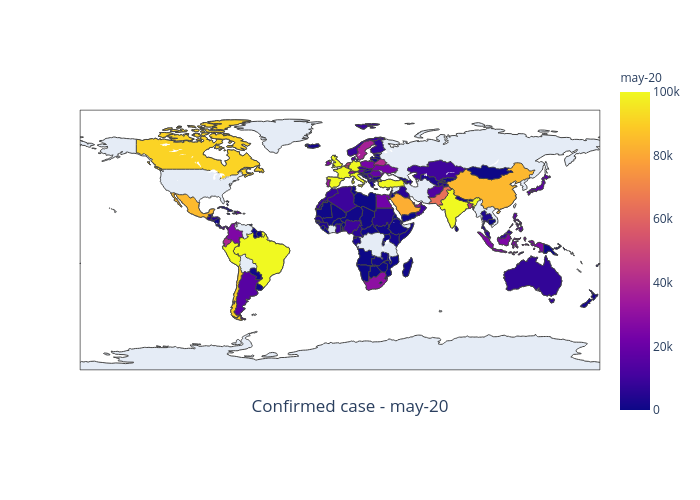

In [13]:
images = []
for month in months :
  images.append(covid_plot( data, month))

# what an image looks like
covid_plot( data, month)

In [0]:
images[0].save('/content/images/imagedraw.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=800, loop=0)